In [1]:
from dino import Experiment
from matplotlib import pyplot as plt

path   = "/data/dkamm/nemo_output/DINO/"

periodic_bathy = Experiment(path, 'PeriodicBathy')
e_minus_p = Experiment(path, 'EmP_IPSL')
no_saltrestoring = Experiment(path, 'NoSaltrestoring')
T_star = Experiment(path, 'T_star_IPSL')

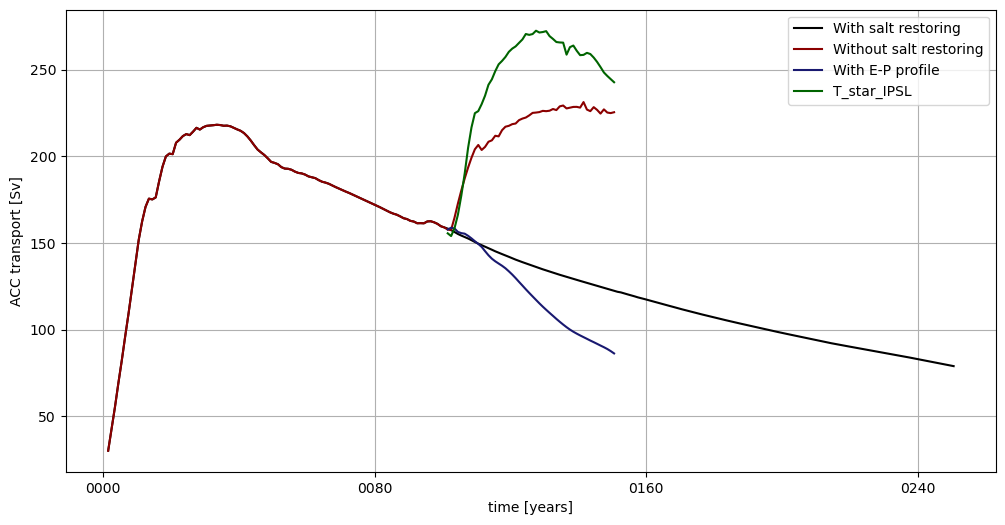

In [2]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(12,6))
periodic_bathy.get_ACC().plot(color='black', label='With salt restoring')
no_saltrestoring.get_ACC().plot(color='darkred', label='Without salt restoring')
e_minus_p.get_ACC().plot(color='midnightblue', label='With E-P profile')
T_star.get_ACC().plot(color='darkgreen', label='T_star_IPSL')
#ACC_emp.plot(color='midnightblue', label='With E - P flux only')
axs.set_ylabel('ACC transport [Sv]')
plt.title('')
plt.xlabel('time [years]')
plt.legend()
plt.grid()

In [2]:
moc = no_saltrestoring.get_MOC(var=(no_saltrestoring.data.vocetr_eff))

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Text(0.5, 1.0, '')

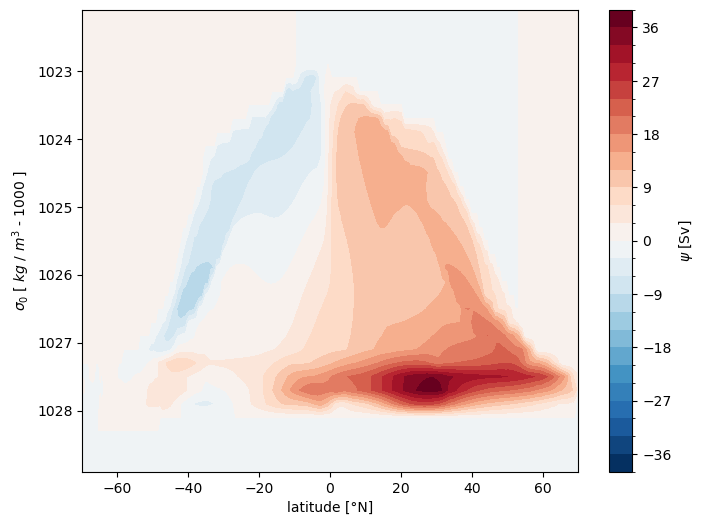

In [4]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,1,figsize=(8,6))
a = (-moc).plot.contourf(x='y_f', y='rhop', cmap='RdBu_r', levels=30, add_colorbar=False)
cbar1 = fig.colorbar(a, ax=axs, label=r'$\psi$ [Sv]')
plt.xlabel('latitude [°N]')
axs.invert_yaxis()
plt.ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
plt.title('')

In [ ]:
import xgcm
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3f'] # Z distances
}


grid = xgcm.Grid(periodic_bathy.data,
        coords={
            "X": {"right": "x_f", "center": "x_c"},
            "Y": {"right": "y_f", "center":"y_c"},
            "Z": {"right": "z_f", "center": "z_c"}
        },
        periodic=False,
        metrics=metrics
)

In [ ]:
#Interpolating on u_f
Data['u_f'] = grid.interp(Data.uoce, 'Y')
Data_no['u_f'] = grid.interp(Data_no.uoce, 'Y')
Data_emp['u_f'] = grid.interp(Data_emp.uoce, 'Y')

#Integrating over depth
Data['U'] = grid.integrate(Data.u_f, 'Z')
Data_no['U'] = grid.integrate(Data_no.u_f, 'Z')
Data_emp['U'] = grid.integrate(Data_emp.u_f, 'Z')

#Cumulative integral over x
Psi = (Data.U[-1,::-1,:] * domcfg.e2f[::-1,:]).cumsum('y_f') / 1e6
Psi_no = (Data_no.U[-1,::-1,:] * domcfg.e2f[::-1,:]).cumsum('y_f') / 1e6
Psi_emp = (Data_emp.U[-1,::-1,:] * domcfg.e2f[::-1,:]).cumsum('y_f') / 1e6

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(16,12), sharey=True)
a = Psi_no.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs[:3], location='bottom', label=r'$\psi$ [Sv]')
b = Psi.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
c = Psi_emp.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[2], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('latitude [°N]')
axs[1].set_ylabel(' ')
axs[2].set_ylabel(' ')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')
axs[2].set_xlabel('longitude [°E]')
axs[0].set_title('Salt restoring according to Caneill')
axs[1].set_title('No salt restoring')
axs[2].set_title('Salt flux through E-P')

In [ ]:
import cf_xarray
import gsw

Data_nosalt = xn.open_nemo(domcfg=domcfg, files=[
        datadir / '../../EminusP/NEVERWORLD_grid_T.nc',
        datadir / '../../EminusP/NEVERWORLD_grid_U.nc',
        datadir / '../../EminusP/NEVERWORLD_grid_V.nc'
    ])

Data_annual_cp = Data_nosalt.isel(z_c=slice(0,-1)).copy()

level_outer_annual = cf_xarray.bounds_to_vertices(Data_annual_cp.deptht_bounds, 'axis_nbounds').load().data

Data_annual_cp = Data_annual_cp.assign_coords({'z_f': level_outer_annual})

grid_annual_cp = xgcm.Grid(Data_annual_cp,
    coords={
        "X": {"center": "x_c"},
        "Y": {"right": "y_f", "center":"y_c"},
        "Z": {"center": "z_c", "outer": "z_f"}
    },
    periodic=False)

In [ ]:
Data_annual_cp['sigma0'] = gsw.sigma0(Data_annual_cp.soce, gsw.CT_from_pt(Data_annual_cp.soce, Data_annual_cp.toce))

In [ ]:
sigma_v_annual = grid_annual_cp.interp(Data_annual_cp.sigma0, 'Y')
sigma_outer_annual = grid_annual_cp.interp(sigma_v_annual, 'Z',  boundary='extend')

### Target values for the new density coordinates

In [ ]:
import numpy as np
sigma_target = np.array([24, 24.2, 24.4, 24.65, 24.9, 25.15, 25.4, 25.65,
                        25.9, 26.15, 26.4, 26.57, 26.75, 26.90, 27.05, 27.17,
                        27.30, 27.37, 27.45, 27.52, 27.58,
                        27.63, 27.68, 27.72, 27.75, 27.78, 27.80, 27.815,
                        27.83, 27.845, 27.86, 27.875, 27.89,
                        27.905, 27.92, 27.935, 27.95, 27.965,
                        27.98, 27.99, 28.01, 28.025,
                        28.04, 28.055, 28.07, 28.085, 28.1, 28.35,
                        28.6, 28.8, 29.1])

### Transforming the meridional transport on density coordinates

In [ ]:
vtra_annual = grid_annual_cp.transform(Data_annual_cp.vocetr_eff,
        'Z',
        sigma_target,
        method='conservative',
        target_data=sigma_outer_annual)

### Computing the meridional overturning

In [ ]:
Over_annual    = vtra_annual.isel(t=-1).sum(dim='x_c')[:,::-1].cumsum('sigma0') / 1e6

In [ ]:
Over_annual = Over_annual.assign_coords(dict({'y_f': domcfg.gphif.isel(x_f=10).values}))

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(12,8))
a = (-Over_annual).plot.contourf(x='y_f', y='sigma0', cmap='RdBu_r', levels=30,ax=axs)
axs.invert_yaxis()
axs.set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs.set_xlabel('latitude [°N]')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
Data_annual_cp.toce.isel(t=-1, y_c=slice(1,40), x_c=slice(1,-1), z_c=0).mean('x_c').plot(ax=axs[0])#.contourf(level=36, yincrease=False, ax=axs[0])
Data_annual_cp.soce.isel(t=-1, y_c=slice(1,40), x_c=slice(1,-1), z_c=0).mean('x_c').plot(ax=axs[1])#.contourf(level=36, yincrease=False, ax=axs[1])

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
Data_annual_cp.toce.isel(t=-1, y_c=slice(1,40), x_c=slice(1,-1), z_c=0).mean('x_c').plot(ax=axs[0])#.contourf(level=36, yincrease=False, ax=axs[0])
Data_annual_cp.soce.isel(t=-1, y_c=slice(1,40), x_c=slice(1,-1), z_c=0).mean('x_c').plot(ax=axs[1])#.contourf(level=36, yincrease=False, ax=axs[1])

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(12,8))
a = Data_annual_cp.sigma0.isel(t=-1, y_c=slice(1,-1), x_c=30).plot.contourf(x='gphit', y='gdept_0', levels=30,ax=axs)
axs.invert_yaxis()
axs.set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs.set_xlabel('latitude [°N]')

In [ ]:
Data_annual_cp.sigma0.isel(t=-1, y_c=slice(-1,1), x_c=30)

In [ ]:
Data_mo = xn.open_nemo(domcfg=domcfg, files=[
        datadir / '../../NoSaltrestoring/NEVERWORLD_grid_T_mo.nc'
    ])

In [ ]:
Data_mo.mldr10_1.groupby("t.month").mean().plot(col='month', col_wrap=4)

### Checking Sea-Surface-Salinity and Fresh-Water-Flux from Sea-Ice and Atmosphere from IPSL CMIP6 

In [ ]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fwf_ice = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/SImon/siflfwbot/gn/latest/siflfwbot_SImon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc',decode_times=False)
sss = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Omon/sos/gn/latest/sos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc',decode_times=False)
sss = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr/latest/pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc',decode_times=False)
sss = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/evspsbl/gr/latest/evspsbl_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc',decode_times=False)

In [ ]:
stat /bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/SImon/siflfwbot/gn/latest/siflfwbot_SImon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc
stat /bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Omon/sos/gn/latest/sos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc
stat /bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr/latest/pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc
stat /bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/evspsbl/gr/latest/evspsbl_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc

In [ ]:
e_minus_p.data

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(16,12), sharey=True)
a = e_minus_p.data.toce.isel(t_y=-1, z_c=slice(0,-1), x_c=slice(1,-1), y_c=slice(1,40)).mean('x_c').plot(ax=axs[2], yincrease=False, y='gdept_1d', add_colorbar=False)
cbar1 = fig.colorbar(a, ax=axs[:3], location='bottom', label=r'T')
no_saltrestoring.data.toce.isel(t_y=-1, z_c=slice(0,-1), x_c=slice(1,-1), y_c=slice(1,40)).mean('x_c').plot(ax=axs[1], yincrease=False, y='gdept_1d', add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax)
periodic_bathy.data.toce.isel(t_y=-1, z_c=slice(0,-1), x_c=slice(1,-1), y_c=slice(1,40)).mean('x_c').plot(ax=axs[0], yincrease=False, y='gdept_1d', add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('depth [m]')
axs[1].set_ylabel(' ')
axs[2].set_ylabel(' ')
axs[0].set_xlabel('latiitude [°E]')
axs[1].set_xlabel('latiitude [°E]')
axs[2].set_xlabel('latiitude [°E]')
axs[0].set_title('Salt restoring according to Caneill')
axs[1].set_title('No salt restoring')
axs[2].set_title('Salt flux through E-P')

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(16,12), sharey=True)
a = e_minus_p.data.soce.isel(t_y=-1, z_c=slice(0,-1), x_c=slice(1,-1), y_c=slice(1,40)).mean('x_c').plot(ax=axs[2], yincrease=False, y='gdept_1d', add_colorbar=False)
cbar1 = fig.colorbar(a, ax=axs[:3], location='bottom', label=r'$\psi$ [Sv]')
no_saltrestoring.data.soce.isel(t_y=-1, z_c=slice(0,-1), x_c=slice(1,-1), y_c=slice(1,40)).mean('x_c').plot(ax=axs[1], yincrease=False, y='gdept_1d', add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax)
periodic_bathy.data.soce.isel(t_y=-1, z_c=slice(0,-1), x_c=slice(1,-1), y_c=slice(1,40)).mean('x_c').plot(ax=axs[0], yincrease=False, y='gdept_1d', add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('depth [m]')
axs[1].set_ylabel(' ')
axs[2].set_ylabel(' ')
axs[0].set_xlabel('latiitude [°E]')
axs[1].set_xlabel('latiitude [°E]')
axs[2].set_xlabel('latiitude [°E]')
axs[0].set_title('Salt restoring according to Caneill')
axs[1].set_title('No salt restoring')
axs[2].set_title('Salt flux through E-P')

In [ ]:
e_minus_p.data

In [2]:
from dino import Experiment
from matplotlib import pyplot as plt
from cmocean import cm 

path   = "/data/dkamm/nemo_output/DINO/"

SaltPassive = Experiment(path, 'SaltPassive')
SaltRestoring = Experiment(path, 'SaltRestoring')

In [4]:
from cmocean import cm 

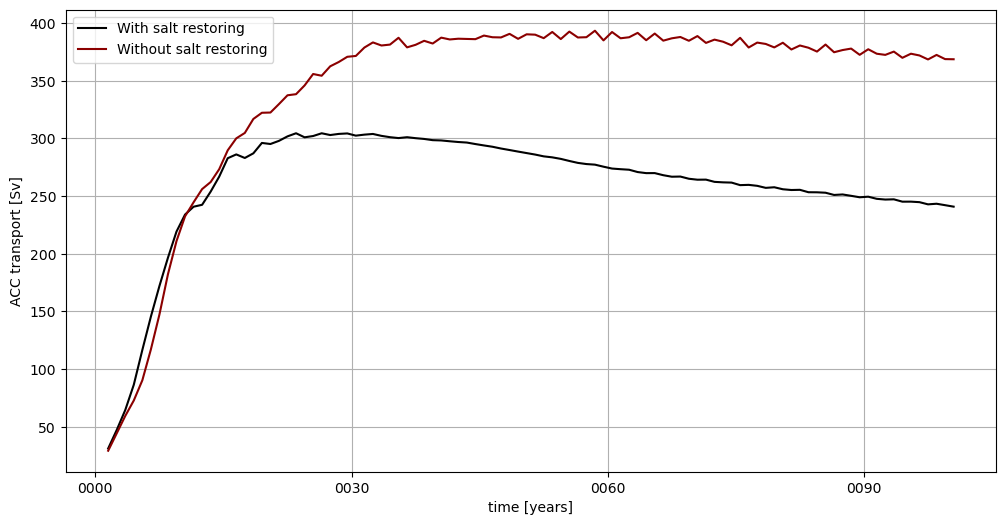

In [3]:
fig, axs = plt.subplots(1,1, figsize=(12,6))
SaltRestoring.get_ACC().plot(color='black', label='With salt restoring')
SaltPassive.get_ACC().plot(color='darkred', label='Without salt restoring')
axs.set_ylabel('ACC transport [Sv]')
plt.title('')
plt.xlabel('time [years]')
plt.legend()
plt.grid()

In [7]:
bts_sp = SaltPassive.get_BTS().isel(t_y=-1)
bts_sr = SaltRestoring.get_BTS().isel(t_y=-1)

Text(0.5, 1.0, '')

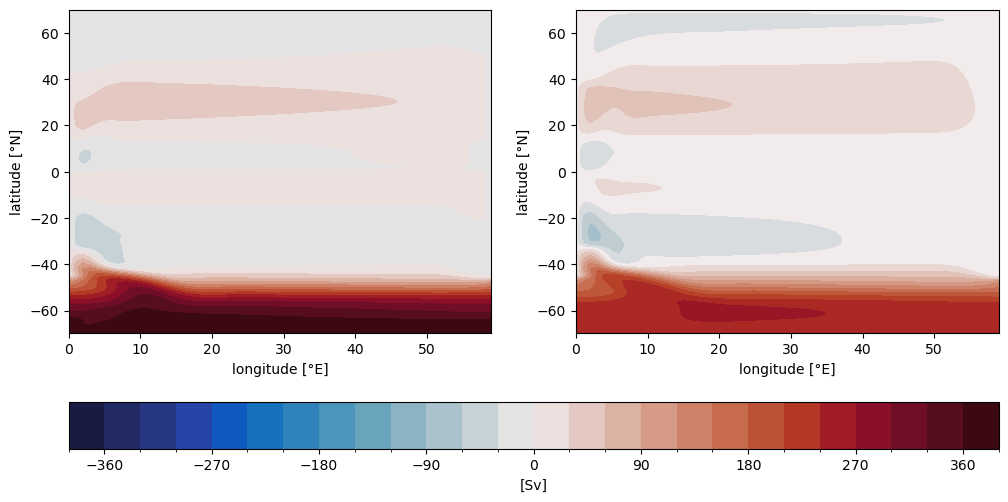

In [10]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
a = bts_sp.plot.contourf(x='glamf', y='gphif', cmap=cm.balance, levels=30, add_colorbar=False, ax=axs[0])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom' , label='[Sv]')
b = bts_sr.plot.contourf(x='glamf', y='gphif', cmap=cm.balance, levels=30, add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax, ax=axs[1])
axs[0].set_ylabel('latitude [°N]')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_ylabel('latitude [°N]')
axs[1].set_xlabel('longitude [°E]')
plt.title('')

In [19]:
moc_sp = SaltPassive.get_MOC(SaltPassive.data.voce + SaltPassive.data.voce_eiv)
moc_sr = SaltRestoring.get_MOC(SaltRestoring.data.voce + SaltRestoring.data.voce_eiv)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

Text(0.5, 1.0, '')

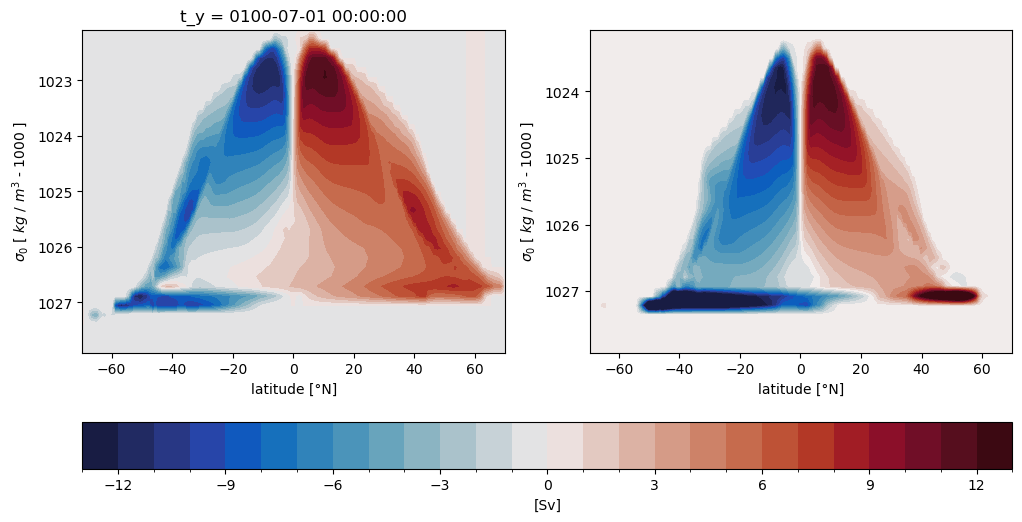

In [20]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
a = (- moc_sp).plot.contourf(x='y_f', y='rhop', cmap=cm.balance, levels=30, add_colorbar=False, ax=axs[0])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom' , label='[Sv]')
b = (- moc_sr).plot.contourf(x='y_f', y='rhop', cmap=cm.balance, levels=30, add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax, ax=axs[1])
axs[0].set_xlabel('latitude [°N]')
axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[1].set_xlabel('latitude [°N]')
axs[1].invert_yaxis()
axs[1].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
plt.title('')

Text(0.5, 1.0, '')

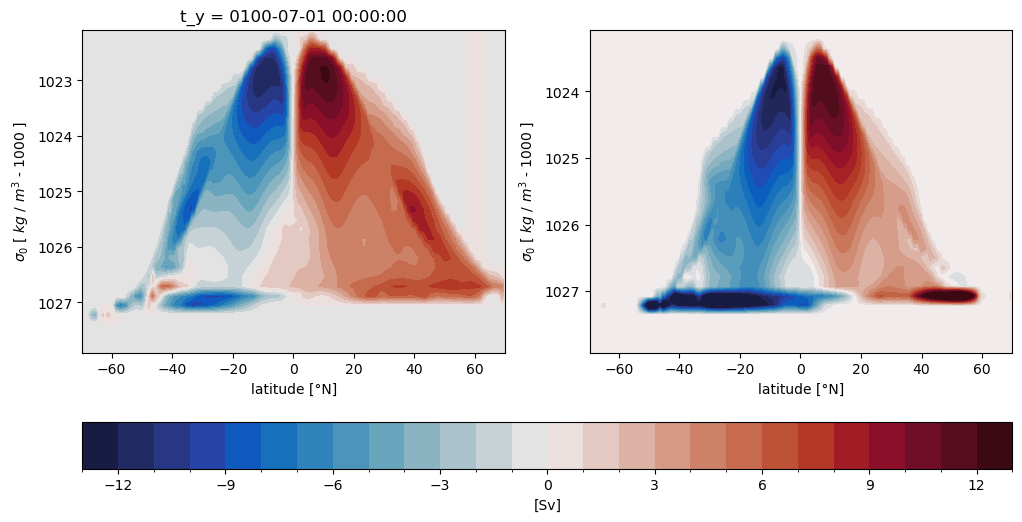

In [16]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
a = (- moc_sp).plot.contourf(x='y_f', y='rhop', cmap=cm.balance, levels=30, add_colorbar=False, ax=axs[0])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom' , label='[Sv]')
b = (- moc_sr).plot.contourf(x='y_f', y='rhop', cmap=cm.balance, levels=30, add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax, ax=axs[1])
axs[0].set_xlabel('latitude [°N]')
axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[1].set_xlabel('latitude [°N]')
axs[1].invert_yaxis()
axs[1].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
plt.title('')

In [17]:
moc_sp_ei = SaltPassive.get_MOC(SaltPassive.data.voce_eiv)
moc_sr_ei = SaltRestoring.get_MOC(SaltRestoring.data.voce_eiv)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

Text(0.5, 1.0, '')

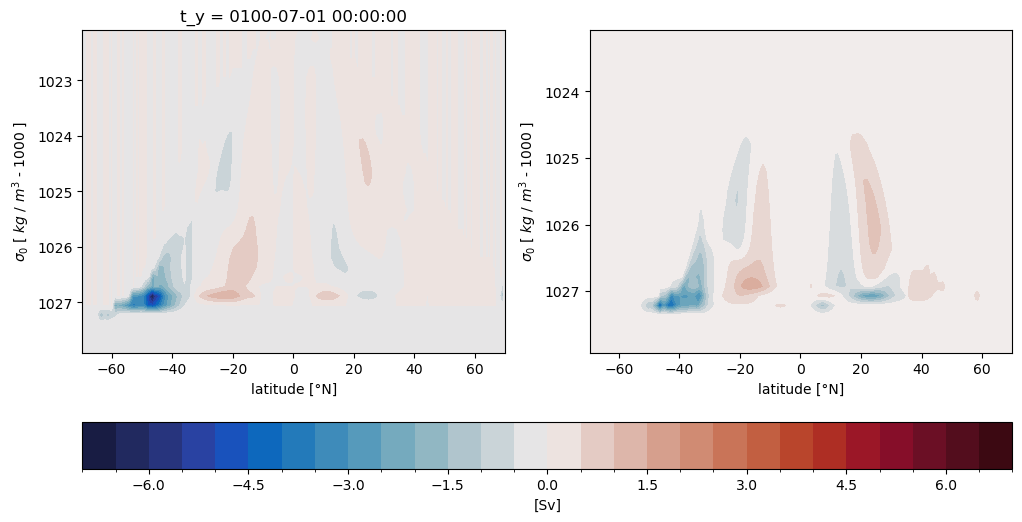

In [18]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
a = (- moc_sp_ei).plot.contourf(x='y_f', y='rhop', cmap=cm.balance, levels=30, add_colorbar=False, ax=axs[0])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom' , label='[Sv]')
b = (- moc_sr_ei).plot.contourf(x='y_f', y='rhop', cmap=cm.balance, levels=30, add_colorbar=False, vmin=cbar1.vmin, vmax=cbar1.vmax, ax=axs[1])
axs[0].set_xlabel('latitude [°N]')
axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[1].set_xlabel('latitude [°N]')
axs[1].invert_yaxis()
axs[1].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
plt.title('')